# Transfert de Style

Ce notebook implémente un algorithme de transfert de style qui fusionne la texture d'une image de style avec la structure d'une image de référence.

## Principe

Le transfert de style consiste à utiliser deux images :
- **Image de style** : Fournit la texture et le style visuel.
- **Image de référence** : Fournit la structure et les formes.

L'objectif est de créer une nouvelle image combinant la texture de l'image de style et la structure de l'image de référence.

Le code diffère que très peu du code de la synthèse d’image par automate cellulaire.

Nous avons ajouté un canal à l’entrée du reseau qui est l’image de référence en noir et blanc pour avoir une attache aux données et des information spatiales sur la référence.

Nous avons également modifié la fonction de perte comme détaillé ci-dessous.


## Fonction de Perte

La fonction de perte utilisée dans ce notebook inclut deux termes principaux :
- **Différence Pixel à Pixel** : Garantit que l'image générée conserve la structure de l'image de référence.
- **Perte de Texture** : Garantit que l'image générée reproduit la texture de l'image de style.

## Instructions d'Utilisation

1. **Dépendances** : Assurez-vous d'avoir installé les bibliothèques nécessaires :
   - `torch` (PyTorch)
   - `numpy`
   - `matplotlib`
   - Tous les modules ou classes personnalisés définis dans ce notebook.

2. **Paramètres Principaux** :
   - `img_path` : Chemin vers l'image de style.
   - `img_ref_path` : Chemin vers l'image de référence.
   - `img_size` : Taille à laquelle les images seront redimensionnées.

3. **Exécution du Notebook** :
   - Définissez les chemins vers vos images et la taille de l'image.
   - Initialisez la classe de perte et le modèle avec ces paramètres.
   - Lancez le processus d'entraînement avec le nombre d'étapes souhaité.
   - Générez l'image finale.

In [8]:
img_path="vangogh.png"
img_ref_path="arch.png"
img_size=128

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from tqdm import tqdm
import datetime
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
# torch.set_default_dtype(torch.float32)



In [10]:

class LossClass:
    def __init__(self, reference_image_path,ref_image_shape_path, ref_im_size) -> None:
        """
        @param reference_image_path: path to the reference image
        @param ref_im_size: size of the reference image (resized to this size)
        """
        # Initialisation of the VGG19 model
        self.vgg_cnn = models.vgg19(weights="IMAGENET1K_V1").features.to(device)

        self.vgg_cnn.requires_grad_(False)

        # initialise l'extraction des couches pour la loss
        self.extracted_layers_indexes = [1, 6, 11, 20, 29]
        self.layers_weights = [1 / n**2 for n in [64, 128, 256, 512, 512]]

        # Contient la réponse des différentes couches de vgg à l'image de référence
        self.vgg_outputs = {}

        def save_output(name):

            # The hook signature
            def hook(module, module_in, module_out) -> None:
                self.vgg_outputs[name] = module_out

            return hook

        # le handle est useless
        for layer in self.extracted_layers_indexes:
            handle = self.vgg_cnn[layer].register_forward_hook(save_output(layer))

        # Charge l'image de référence et la prépare (resize, normalisation, etc.)
        self.reference_img = prep_img_file(reference_image_path, ref_im_size).to(device)
        self.reference_shape_img = prep_img_file(ref_image_shape_path, ref_im_size).to(device)

        # Calcul de la matrice de gramm pour chaque couche
        self.vgg_cnn(self.reference_img / 0.25)
        self.gramm_targets = [
            gramm(self.vgg_outputs[key]) for key in self.extracted_layers_indexes
        ]
        self.vgg_cnn(to_grey_3ch(self.reference_shape_img,ref_im_size) / 0.25)
        self.shape_targets=[self.vgg_outputs[key] for key in self.extracted_layers_indexes]





    def compute_loss(self, imgs):
        # img : batch de 4 images de taille 12x128x128

        total_loss = torch.tensor(0.0).to(device)

        # Prepare texture data
        synth = []
        for i in range(4):
            synth.append(imgs[i][:3].unsqueeze(0))

        # Forward pass using target texture for get activations of selected layers (outputs). Calculate gram Matrix for those activations
        for x in synth:
            losses = []
            shape_losses=[]
            self.vgg_cnn(x / 0.25)
            synth_outputs = [
                self.vgg_outputs[key] for key in self.extracted_layers_indexes
            ]
            # calcul des loss pour toutes les couches

            for activations in zip(
                synth_outputs, self.gramm_targets, self.layers_weights
            ):
                losses.append(gram_loss(*activations).unsqueeze(0))

            self.vgg_cnn(to_grey_3ch(x,128)/0.25)
            synth_outputs = [
                self.vgg_outputs[key] for key in self.extracted_layers_indexes
            ]
            for activations in zip(
                synth_outputs, self.shape_targets, self.layers_weights
            ):
                shape_losses.append(mse_loss_layers(*activations).unsqueeze(0))




            total_loss = total_loss + torch.cat(losses).sum() + 0.1*torch.cat(shape_losses).sum()
        clip_loss = torch.sum(torch.abs(imgs - imgs.clip(-1, 1))) / torch.numel(imgs)
        return total_loss + clip_loss




In [11]:

image_tex = prep_img_file(img_path, img_size).to(device)
image_ref_rgb = prep_img_file(img_ref_path, img_size).to(device)
image_ref = torch.mean(image_ref_rgb, axis=1).reshape(1, 1, img_size, img_size)

In [12]:

class RecursiveNN(nn.Module):
    def __init__(
        self,
        loss: LossClass,
        img_size=img_size,
        img_layer_depth=12,
        cpool_size=1024,
        learning_rate=2e-4,
        bach_size=4,
    ):
        super(RecursiveNN, self).__init__()

        self.loss = loss
        self.img_size = img_size
        self.img_layer_depth = img_layer_depth
        self.cpool_size = cpool_size
        self.learning_rate = learning_rate
        self.bach_size = bach_size

        self.ident = torch.tensor(
            [[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]
        ).to(device)
        self.sobel_x = torch.tensor(
            [[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]
        ).to(device)
        self.lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]]).to(
            device
        )

        self.cn1 = nn.Conv2d(
            4 * (img_layer_depth+1), 96, kernel_size=1, padding=0, stride=1
        ).to(device)

        self.cn2 = nn.Conv2d(
            96,
            img_layer_depth,
            kernel_size=1,
            padding=0,
            stride=1,
            bias=False,  # Semble vraiment être important pour éviter la divergence
        ).to(device)

        # self.cn1.weight.data.zero_() Surtout pas, augmente énormément le temps de convergence
        self.cn2.weight.data.zero_()

        # Création de la pool d'images (avec les channels en plus)
        self.cpool = torch.rand(
            size=(self.cpool_size, self.img_layer_depth, self.img_size, self.img_size),
            dtype=torch.float32,
            requires_grad=False,
        ).to(device)

        self.total_training_steps = 0
        self.total_params = sum(p.numel() for p in self.parameters())

    def forward(self, x0):
        """ "from the paper"""
        batch_ref = torch.cat([image_ref]*len(x0))
        x = torch.cat([x0, batch_ref], axis=1)

        b, ch, h, w = x.shape
        filters = torch.stack([self.ident, self.sobel_x, self.sobel_x.T, self.lap,
                               ]).to(
            device
        )

        y = x.reshape(b * ch, 1, h, w)
        y = torch.nn.functional.pad(y, [1,1,1,1], "circular")
        y = torch.nn.functional.conv2d(y, filters[:, None])
        y = y.reshape(b, -1, h, w)

        """end of paper"""

        out = self.cn2(F.relu(self.cn1(y)))

        return out + x0

    def render(self, it, width, height, save=True):

        x = torch.rand(
            size=(1, self.img_layer_depth, width, height), dtype=torch.float32
        ).to(device)
        # remplace un des éléments du batch par du bruit
        with torch.no_grad():
            for _ in range(it):
                x = self(x)

        if save:
            create_directory_if_not_exists("output")
            plt.imsave(
                f"output/{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{it}_iterations.png",
                to_img(x),
            )
        return x
    def start_training(self, nb_steps, debug=False, save_on_interrupt=True):

        optim = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.train()  # met le modèle en mode entrainement
        loss_history = []

        # Progress bar
        pbar = tqdm(total=nb_steps)

        try:
            for i in range(nb_steps):

                indices = torch.randint(
                    low=0, high=self.cpool_size, size=(self.bach_size,)
                )
                # print(indices)
                current_batch = self.cpool[indices]

                # remplace une image du batch par du bruit
                current_batch[0] = torch.rand(
                    size=(self.img_layer_depth, self.img_size, self.img_size),
                    dtype=torch.float32,
                    requires_grad=False,
                ).to(device)
                # le clone est nécessaire ? Probablement pas, faut juste remplace le bon dans la pool
                current_batch = current_batch.clone().detach()

                # On applique itérativement le modèle sur l'image
                niter = torch.randint(low=32, high=64, size=(1,))
                for _ in range(niter):
                    current_batch = self(current_batch)

                L = self.loss.compute_loss(current_batch)

                with torch.no_grad():
                    L.backward()
                    for p in self.parameters():
                        p.grad /= p.grad.norm() + 1e-8  # normalize gradients
                    optim.step()
                    optim.zero_grad()

                # On met à jour la pool d'images
                self.cpool[indices] = current_batch.detach()

                pbar.set_description(
                    f"\rstep {i+1} / {nb_steps} | loss: {L.item():.3e} | extremums: [{torch.min(current_batch):.3e}, {torch.max(current_batch):.3e}]"
                )
                loss_history.append(L.item())
                pbar.update()
                self.total_training_steps += 1
        except KeyboardInterrupt:
            print("\ntraining interrupted !")

            if save_on_interrupt:
                self.save_weights()
            quit(1)

        pbar.close()

        # save loss history
        #plt.plot(loss_history)
        #plt.xlabel("Training Step")
        #plt.ylabel("Loss")
        #plt.title("Loss History")
        #plt.savefig(
        #    f"loss_history_{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{self.total_training_steps}_steps.png"
        #)
        self.save_weights(save_loss=True)

    def save_weights(self, dir_path="trained_model",save_loss = True) -> None:


        create_directory_if_not_exists(dir_path)
        # cd trained_models
        os.chdir(dir_path)
        pathmodel = f"model_{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{self.total_training_steps}_steps"
        create_directory_if_not_exists(pathmodel)

        filename = "model.pth"
        torch.save(self.state_dict(), f"{pathmodel}/{filename}")
        if save_loss:
            plt.savefig(f"{pathmodel}/loss.png")
        os.chdir('..')
    def load_weights(self, path):
        self.load_state_dict(torch.load(path))





# Training
La variable steps permet de choisir le nombre d'étapes pour le training.
Une fois le modèle entrainé, les poids sont stockés automatiquement sur la machine permettant ainsi de les utiliser directment dans la partie render par la suite.

step 3000 / 3000 | loss: 2.959e-05 | extremums: [-1.023e+00, 9.880e-01]: 100%|██████████| 3000/3000 [12:31<00:00,  3.99it/s]


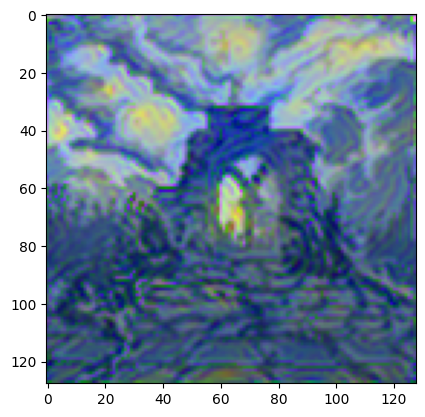

In [13]:


steps=3000
if __name__ == "__main__":

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    np.random.seed(42)

    l = LossClass(img_path,img_ref_path, img_size)
    model = RecursiveNN(l)

    model.start_training(steps)


    finish = model.render(steps, width=img_size, height=img_size)

    plt.imshow(to_img(finish))
    plt.show()
    torch.cuda.empty_cache()

# Render
Cette partie peremt d'utilsier les poids sauvegardés après entrainement pour faire le transfert de style sur les images.

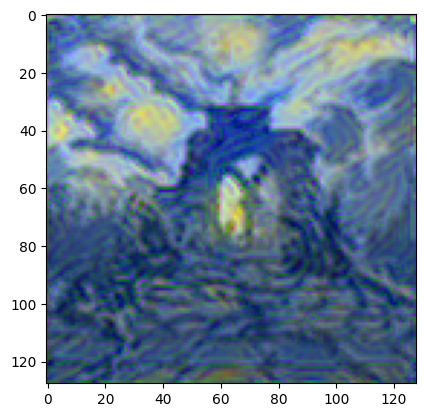

In [17]:
renderstep=500
l = LossClass(img_path,img_ref_path, img_size)
model = RecursiveNN(l)
model.load_weights("model_arch_vangogh.pth")


finish = model.render(renderstep, width=img_size, height=img_size)

plt.imshow(to_img(finish))
plt.show()
torch.cuda.empty_cache()